<h2 style='color:blue' align='center'>Sports Celebrity Image Classification<h2>

Special thanks to Debjyoti Paul (My data scientist friend at Amazon) for help with this project

In [1]:
#`https://www.tutorialspoint.com/how-to-detect-eyes-in-an-image-using-opencv-python?key=detect+face`
#`https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_objdetect/py_face_detection/py_face_detection.html`
#`https://github.com/codebasics/py/tree/master/DataScience/CelebrityFaceRecognition`
#steps
#1. import libraries
#2. use cv2 for color image
#3. convert image into gray
#4. detect face n eyes using haar-cascade
#5. crop images for faces/ store in cropped dir
import numpy as np
import cv2
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore', '.*do not.*',)


<h3 style='color:purple'>(1) Preprocessing: Detect face and eyes</h3>

#### When we look at any image, most of the time we identify a person using a face. An image might contain multiple faces, also the face can be obstructed and not clear. The first step in our pre-processing pipeline is to detect faces from an image. Once face is detected, we will detect eyes, if two eyes are detected then only we keep that image otherwise discard it.</h4>

#### Now how do you detect face and eyes?

We will use haar cascade from opencv for this. Here is an article on this: https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_objdetect/py_face_detection/py_face_detection.html?highlight=haar

((555, 700, 3),
 array([200, 179, 157], dtype=uint8),
 <matplotlib.image.AxesImage at 0x7fcd23105f10>)

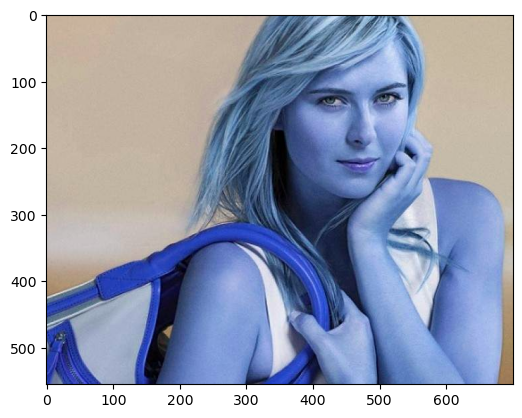

In [2]:
img = cv2.imread('./test_images/sharapova1.jpg') #3 dims
img.shape, img[0][0], plt.imshow(img)

((555, 700), <matplotlib.image.AxesImage at 0x7fcd23822a30>)

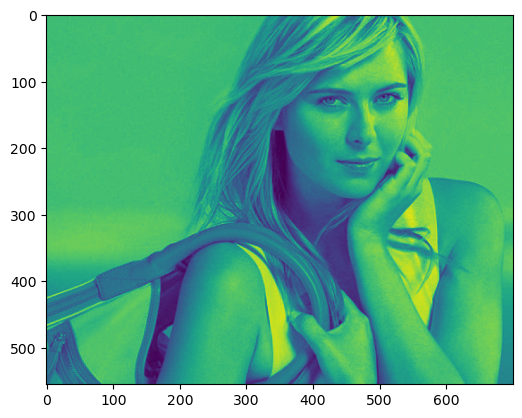

In [3]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #2 dims
(gray.shape, plt.imshow(gray))

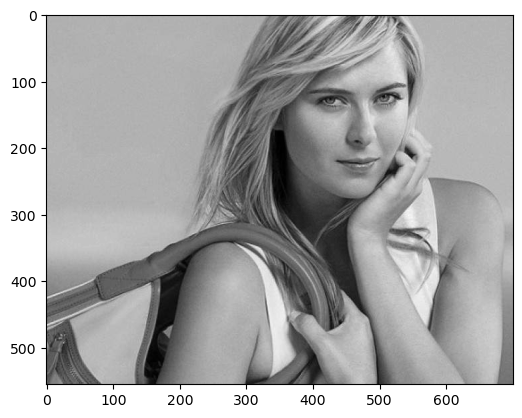

In [4]:
plt.imshow(gray, cmap='gray')

In [5]:
#code: `https://www.bogotobogo.com/python/OpenCV_Python/python_opencv3_Image_Object_Detection_Face_Detection_Haar_Cascade_Classifiers.php`
face_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_eye.xml')
#consider only gray image

faces = face_cascade.detectMultiScale(gray, 1.3, 5) 
#yields coordinates for upper-left-corner coordinates, width and height
faces

array([[352,  38, 233, 233]], dtype=int32)

In [6]:
#(x,y)->upper left cordinates, #(w,h)->width, height
(x,y,w,h) = faces[0]
x,y,w,h

(352, 38, 233, 233)

((555, 700, 3), <matplotlib.image.AxesImage at 0x7fcd23983d60>)

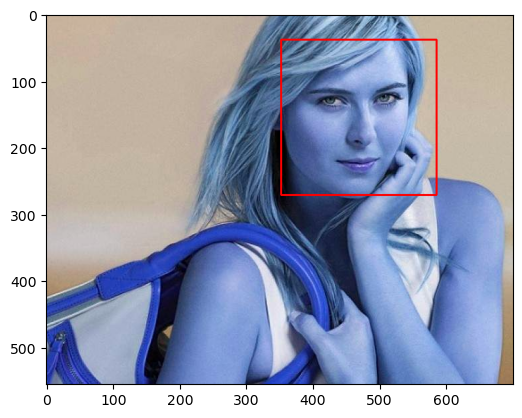

In [7]:
#face in the rectangle as detected by cv2.CascadeClassifier
face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
face_img.shape, plt.imshow(face_img)

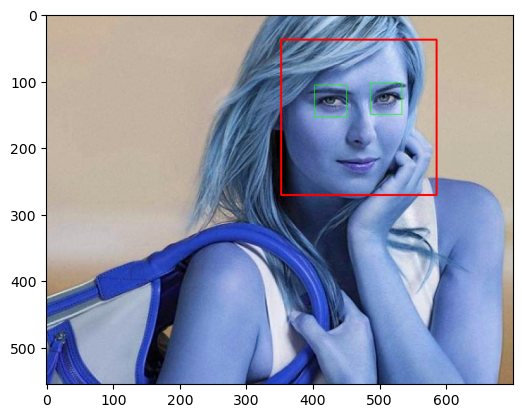

In [8]:
#detect eyes within each face
#this snipet of code has been copied from opencv documentation site
#https://www.bogotobogo.com/python/OpenCV_Python/python_opencv3_Image_Object_Detection_Face_Detection_Haar_Cascade_Classifiers.php
cv2.destroyAllWindows()
for (x,y,w,h) in faces:
    
    #rectangle: (x,y): upper-left-corner of rectangle
    #          (w, h): width, height of rectangle
    #       (255,0,0): red color rectangle
    #               2: line width
    
    face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = face_img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    
    for (ex,ey,ew,eh) in eyes:
        
    #rectangle: (ex,ey): upper-left-corner of rectangle
    #          (ew, eh): width, height of rectangle
    #         (0,255,0): green color rectangle
    #                 2: line width
    
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),1)
        

plt.figure()
plt.imshow(face_img, cmap='gray')
plt.show()

<h3 style='color:purple'>(2) Preprocessing: Crop the facial region of the image</h3>

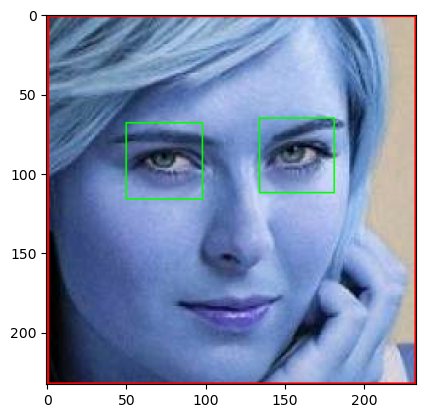

In [9]:
plt.imshow(roi_color, cmap='gray')

In [10]:
cropped_img = np.array(roi_color)
cropped_img.shape

(233, 233, 3)

<h3 style='color:purple'>(3) Preprocessing: Use wavelet transform as a feature for traning our model</h3>

#### In wavelet transformed image, you can see edges clearly and that can give us clues on various facial features such as eyes, nose, lips etc

### Wavelet transform

In [11]:
import numpy as np
import pywt 

def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale, step-1
    imArray = cv2.cvtColor( imArray, cv2.COLOR_RGB2GRAY )
    #convert to float, step-2
    imArray =  np.float32(imArray) 
    imArray /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

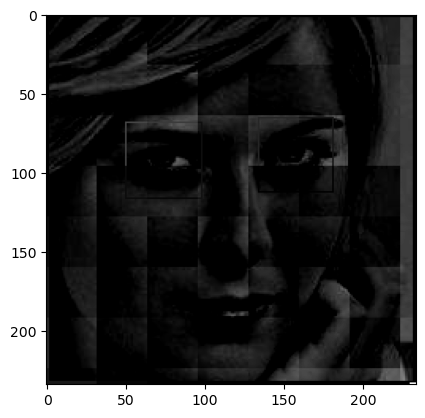

In [12]:
im_har = w2d(cropped_img,'db1', 5)
plt.imshow(im_har, cmap='gray')

#### You can see above a wavelet transformed image that gives clues on facial features such as eyes, nose, lips etc. This along with raw pixel image can be used as an input for our classifier

<h3 style='color:purple'>(3) Preprocessing: Load image, detect face. If eyes >=2, then save and crop the face region</h3>

####  Lets write a python function that can take input image and returns cropped image (if face and eyes >=2 are detected)

In [13]:
def get_cropped_image_if_2_eyes(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x,y,w,h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) >= 2:
            return roi_color

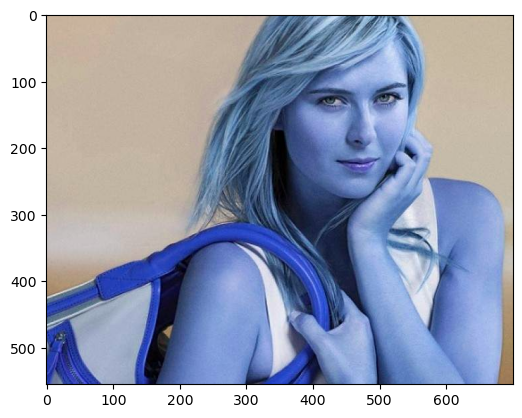

In [14]:
original_image = cv2.imread('./test_images/sharapova1.jpg')
plt.imshow(original_image)

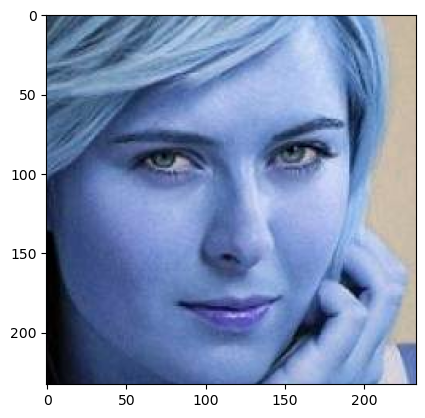

In [15]:
cropped_image = get_cropped_image_if_2_eyes('./test_images/sharapova1.jpg')
plt.imshow(cropped_image)

**In below image face is not very clear and it doesn't have two eyes clearly visible**

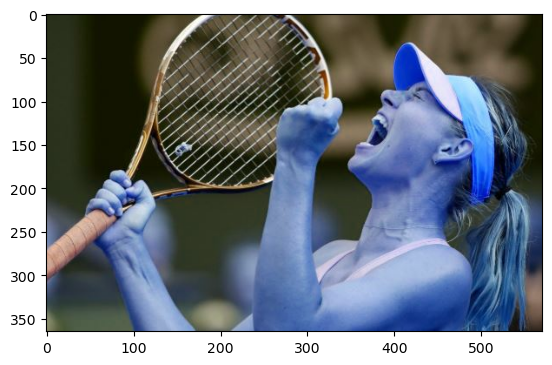

In [16]:
org_image_obstructed = cv2.imread('./test_images/sharapova2.jpg')
plt.imshow(org_image_obstructed)

In [17]:
cropped_image_no_2_eyes = get_cropped_image_if_2_eyes('./test_images/sharapova2.jpg')
cropped_image_no_2_eyes

**Above cropped_image_no_2_eyes is None which means we should ignore this image and we will not use such image for model training**

In [18]:
path_to_data = "./dataset/"
path_to_cr_data = "".join((path_to_data, "cropped/"))
path_to_cr_data

'./dataset/cropped/'

In [19]:
#create a list with existing paths to all dir names 
import os
img_dirs = []

for entry in os.scandir(path_to_data):
    if not entry.name.startswith('.') and entry.name != 'cropped':
        img_dirs.append(entry.path)
img_dirs

['./dataset/maria_sharapova',
 './dataset/virat_kohli',
 './dataset/lionel_messi',
 './dataset/serena_williams',
 './dataset/roger_federer']

**Go through all images in dataset folder and create cropped images for them. There will be cropped folder inside dataset folder after you run this code**

In [20]:
#create a dir to store cropped images of all existing images wrt dir names
#we check if this dir already exists from previous code runs, delete if yes
import shutil
if os.path.exists(path_to_cr_data):
    shutil.rmtree(path_to_cr_data)
os.mkdir(path_to_cr_data)

In [21]:
#handling cropped images from all image dirs
cropped_image_dirs = []
celebrity_file_names_dict = {}

for img_dir in img_dirs:
    count = 1
    celebrity_name = img_dir.split('/')[-1]
    celebrity_file_names_dict[celebrity_name] = []
    
    for entry in os.scandir(img_dir):
        roi_color = get_cropped_image_if_2_eyes(entry.path)
        #if face/eyes are clearly visible
        if roi_color is not None:
            cropped_folder = ''.join((path_to_cr_data, celebrity_name))
            
            if not os.path.exists(cropped_folder):
                os.makedirs(cropped_folder)
                cropped_image_dirs.append(cropped_folder)
                print("Generating cropped images in folder: ", cropped_folder)
            
            cropped_file_name = ''.join((celebrity_name, f'{count}', '.png'))
            cropped_file_path = "/".join((cropped_folder, cropped_file_name))
            cv2.imwrite(cropped_file_path, roi_color)
            celebrity_file_names_dict[celebrity_name].append(cropped_file_path)
            count += 1
#(order) and lenghts: {'(1)maria': 35, '(2)virat_kohli': 48, '(3)lionel_messi': 39, '(4)': 35, '(5)roger_federer': 30}

Generating cropped images in folder:  ./dataset/cropped/maria_sharapova
Generating cropped images in folder:  ./dataset/cropped/virat_kohli
Generating cropped images in folder:  ./dataset/cropped/lionel_messi
Generating cropped images in folder:  ./dataset/cropped/serena_williams
Generating cropped images in folder:  ./dataset/cropped/roger_federer


### Now you should have cropped folder under datasets folder that contains cropped images

### Manually examine cropped folder and delete any unwanted images

In [22]:
# celebrity_file_name_dict = dict()
#names converted into nums
class_dict = dict() 

count = 0
for img_dir in cropped_image_dirs:
    celebrity_name = img_dir.split('/')[-1]
    class_dict[celebrity_name] = count
    
    file_list = list()
    for entry in os.scandir(img_dir):
        file_list.append(entry.path)
        
    celebrity_file_names_dict[celebrity_name] = file_list
    count += 1
    
print(class_dict)
celebrity_file_names_dict[celebrity_name][:3]

{'maria_sharapova': 0, 'virat_kohli': 1, 'lionel_messi': 2, 'serena_williams': 3, 'roger_federer': 4}


['./dataset/cropped/roger_federer/roger_federer55.png',
 './dataset/cropped/roger_federer/roger_federer41.png',
 './dataset/cropped/roger_federer/roger_federer2.png']

### Images in cropped folder can be used for model training. We will use these raw images along with wavelet transformed images to train our classifier. Let's prepare X and y now

In [23]:
X, y = [], []
for celebrity_name, training_files in celebrity_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        if img is None:
            continue
        scalled_raw_img = cv2.resize(img, (32, 32))
        img_har = w2d(img,'db1', 5)
        scalled_img_har = cv2.resize(img_har, (32, 32))
        combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_img_har.reshape(32*32,1)))
        X.append(combined_img)
        y.append(class_dict[celebrity_name])  
celebrity_name #last folder iterated

'roger_federer'

In [24]:
print(f'{len(scalled_raw_img)= }, {len(scalled_raw_img[0])= },\n{len(img_har)= }, {len(img_har[0])= },\n{len(scalled_img_har)= }, {len(scalled_img_har[0])= },\n{len(combined_img)= }, {combined_img= }')

len(scalled_raw_img)= 32, len(scalled_raw_img[0])= 32,
len(img_har)= 152, len(img_har[0])= 152,
len(scalled_img_har)= 32, len(scalled_img_har[0])= 32,
len(combined_img)= 4096, combined_img= array([[13],
       [16],
       [24],
       ...,
       [ 2],
       [ 5],
       [ 2]], dtype=uint8)


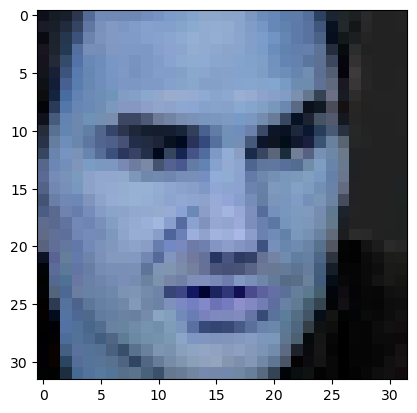

In [25]:
plt.imshow(scalled_raw_img)

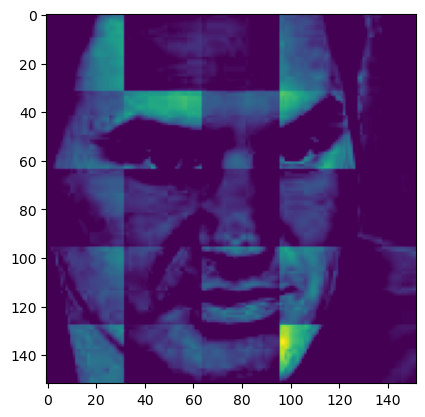

In [26]:
plt.imshow(img_har)

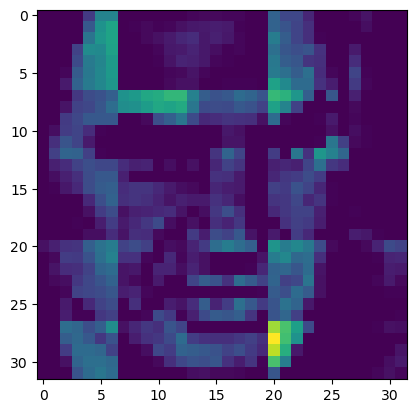

In [27]:
plt.imshow(scalled_img_har)

In [28]:
scalled_raw_img.shape, scalled_img_har.shape

((32, 32, 3), (32, 32))

In [29]:
combined_img.shape

(4096, 1)

In [30]:
len(combined_img[0])

1

In [31]:
combined_img[0], combined_img[-1]

(array([13], dtype=uint8), array([2], dtype=uint8))

In [32]:
len(combined_img)

4096

In [33]:
len(X[0])

4096

In [34]:
32*32*3 + 32*32

4096

In [35]:
X[0]

array([[43],
       [43],
       [43],
       ...,
       [ 0],
       [ 0],
       [18]], dtype=uint8)

In [36]:
y[0]

0

In [37]:
len(X)

308

In [38]:
X = np.array(X).reshape(len(X),4096).astype(float)
X.shape

(308, 4096)

### Data cleaning process is done. Now we are ready to train our model

We will use SVM with rbf kernel tuned  with heuristic finetuning

In [39]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'rbf', C = 10))])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.8441558441558441

In [41]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.78      0.64      0.70        11
           1       0.94      1.00      0.97        16
           2       0.94      0.89      0.92        19
           3       0.77      0.81      0.79        21
           4       0.73      0.80      0.76        10

    accuracy                           0.84        77
   macro avg       0.83      0.83      0.83        77
weighted avg       0.84      0.84      0.84        77



### Let's use GridSearch to try out different models with different paramets. Goal is to come up with best modle with best fine tuned parameters

In [42]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [43]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [44]:
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,svm,0.896022,"{'svc__C': 10, 'svc__kernel': 'rbf'}"
1,random_forest,0.813784,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.879093,{'logisticregression__C': 1}


In [45]:
best_estimators

{'svm': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('svc', SVC(C=10, gamma='auto', probability=True))]),
 'random_forest': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier',
                  RandomForestClassifier(n_estimators=10))]),
 'logistic_regression': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression',
                  LogisticRegression(C=1, solver='liblinear'))])}

In [46]:
best_estimators['svm'].score(X_test,y_test)

0.8441558441558441

In [47]:
best_estimators['random_forest'].score(X_test,y_test)

0.7792207792207793

In [48]:
best_estimators['logistic_regression'].score(X_test,y_test)

0.8831168831168831

In [49]:
best_estimator_dict = {}
for clf in best_estimators:
    best_estimator_dict[clf] = best_estimators[clf].score(X_test, y_test)
best_estimator_dict
best_estimator_df = pd.DataFrame.from_dict(best_estimator_dict, orient='index', columns=['Score'])
best_estimator_df

,Score
svm,0.844156
random_forest,0.779221
logistic_regression,0.883117


In [50]:
best_clf = best_estimators['svm']
best_clf

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=10, gamma='auto', probability=True))])

In [51]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_clf.predict(X_test))
cm

array([[ 7,  1,  1,  1,  1],
       [ 0, 16,  0,  0,  0],
       [ 0,  0, 17,  2,  0],
       [ 2,  0,  0, 17,  2],
       [ 0,  0,  0,  2,  8]])

Text(95.72222222222221, 0.5, 'Truth')

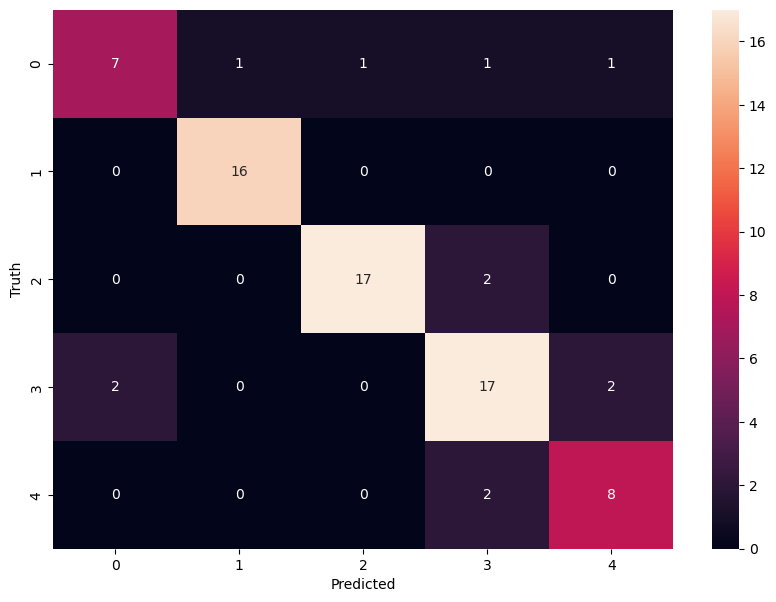

In [52]:
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [53]:
class_dict

{'maria_sharapova': 0,
 'virat_kohli': 1,
 'lionel_messi': 2,
 'serena_williams': 3,
 'roger_federer': 4}

### Save the trained model

In [54]:
!pip install joblib
import joblib 
# Save the model as a pickle in a file 
joblib.dump(best_clf, 'saved_model.pkl') 


[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


['saved_model.pkl']

### Save class dictionary

In [55]:
import json
with open("class_dictionary.json","w") as f:
    f.write(json.dumps(class_dict))
'Code Finished...'

'Code Finished...'

In [56]:
#wavelets
#https://www.kaggle.com/code/asauve/a-gentle-introduction-to-wavelet-for-data-analysis